In [1]:
import numpy as np
import sklearn as sk
import pylab as plt
import pandas as pd
import os
import torch
from tqdm.auto import tqdm

from sklearn.ensemble import RandomForestClassifier
from common import gsave, gload
from nde.uci import get_uci_info, load_uci

In [2]:
df = gload('gs://ANONYMOUS/tmp/results/uci_df')

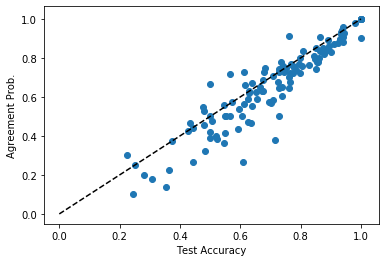

In [3]:
plt.scatter(df['acc1'], df['aggr'])
plt.xlabel('Test Accuracy')
plt.ylabel('Agreement Prob.')
t = np.linspace(0, 1, 10)
plt.plot(t, t, 'k--')

In [47]:
def clopper_pearson(k,n,alpha=0.05):
    """
    alpha confidence intervals for a binomial distribution of k expected successes on n trials
    from: https://gist.github.com/DavidWalz/8538435
    
    alpha=0.05 <==> 95% confidence interval
    """
    import scipy.stats
    lo = scipy.stats.beta.ppf(alpha/2, k, n-k+1)
    hi = scipy.stats.beta.ppf(1 - alpha/2, k+1, n-k)
    if k == 0:
        lo = 0.0
    if k == n:
        hi = 1.0 # NaNs in the above
    return lo, hi

clopper_pearson(70, 100, alpha=0.05)

(0.6001853238201958, 0.7875935795104634)

(2, 92)


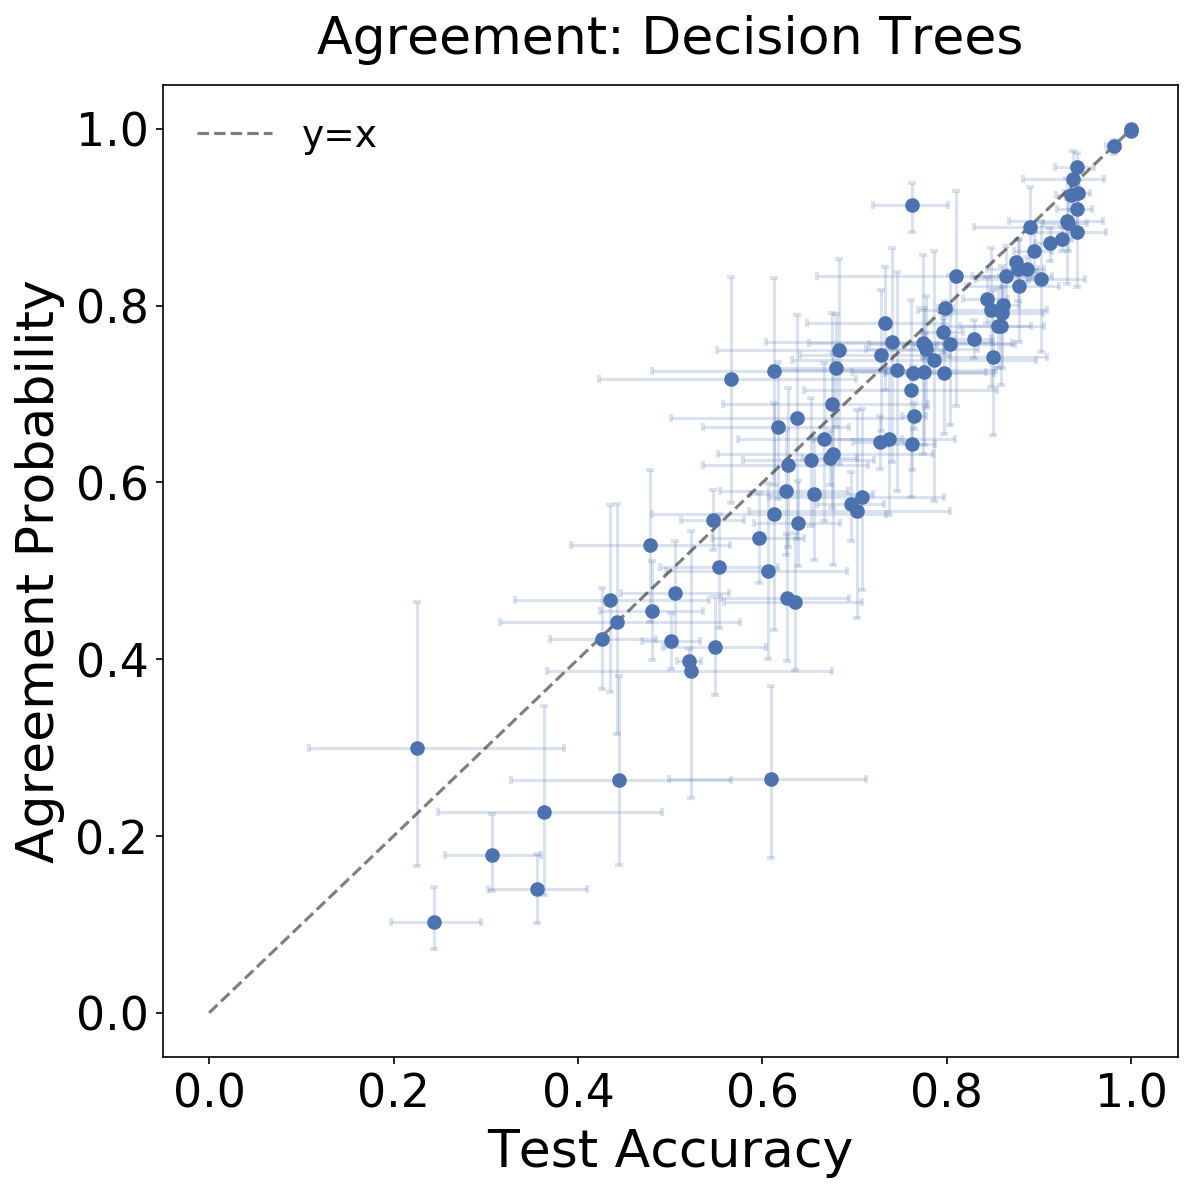

In [166]:
def plot(acc1, acc2, aggr, n_te):
    errs_acc  = [clopper_pearson(int(a1 * nte), nte) for a1, nte in zip(acc1, n_te)]
    errs_aggr = [clopper_pearson(int(ag * nte), nte) for ag, nte in zip(aggr, n_te)]
    
    xerr = np.abs(np.array(errs_acc).T - acc1)
    yerr = np.abs(np.array(errs_aggr).T - aggr)
    print(xerr.shape)
        
    plt.style.reload_library()
    plt.style.use('~/ANONYMOUS-exp/nde/common/mplstyles/paper.mpl')
    fig, ax = plt.subplots()
    markers, caps, bars = ax.errorbar(acc1, aggr, xerr=xerr, yerr=yerr,
            fmt='o',
            #ecolor='black',
            capsize=2, capthick=2)
    
    ax.set_xlabel('Test Accuracy')
    ax.set_ylabel('Agreement Probability')
    ax.set_title('Agreement: Decision Trees')
#     ax.set_ylim((0, 1))
#     ax.set_xlim((0, 1))
    t = np.linspace(0, 1, 10)
    ax.plot(t, t, 'k--', label='y=x', alpha=0.5)
    ax.legend()

    # loop through bars and caps and set the alpha value
    [bar.set_alpha(0.2) for bar in bars]
    [cap.set_alpha(0.2) for cap in caps]
    return fig, ax

    
def plot_df(df):
    return plot(df['acc1'].to_numpy(), df['acc2'].to_numpy(), df['aggr'].to_numpy(), df['n_te'].to_numpy())
    

fig, ax = plot_df(df[df['n'] >= 200])
fig.tight_layout()
fig.savefig('./figs/uci_agreement200_single.png', bbox_inches = 'tight')

In [89]:
df[df['n'] >= 200].sort_values('acc1')

,name,n,n_tr,n_te,num_classes,num_features,acc1,acc2,aggr
41,heart-va,200,80,40,5,12,0.225000,0.275000,0.300000
84,plant-margin,1600,640,320,100,64,0.243750,0.243750,0.103125
85,plant-shape,1600,640,320,100,64,0.306250,0.240625,0.178125
86,plant-texture,1599,639,321,100,64,0.355140,0.289720,0.140187
88,primary-tumor,330,132,66,15,17,0.363636,0.409091,0.227273
...,...,...,...,...,...,...,...,...,...
31,energy-y1,768,307,154,3,8,0.941558,0.935065,0.883117
113,wall-following,5456,2182,1092,4,24,0.942308,0.973443,0.927656
106,thyroid,7200,2880,1440,3,21,0.981250,0.988194,0.980556
101,statlog-shuttle,58000,23200,11600,7,9,0.999138,0.998879,0.998190


(2, 121)


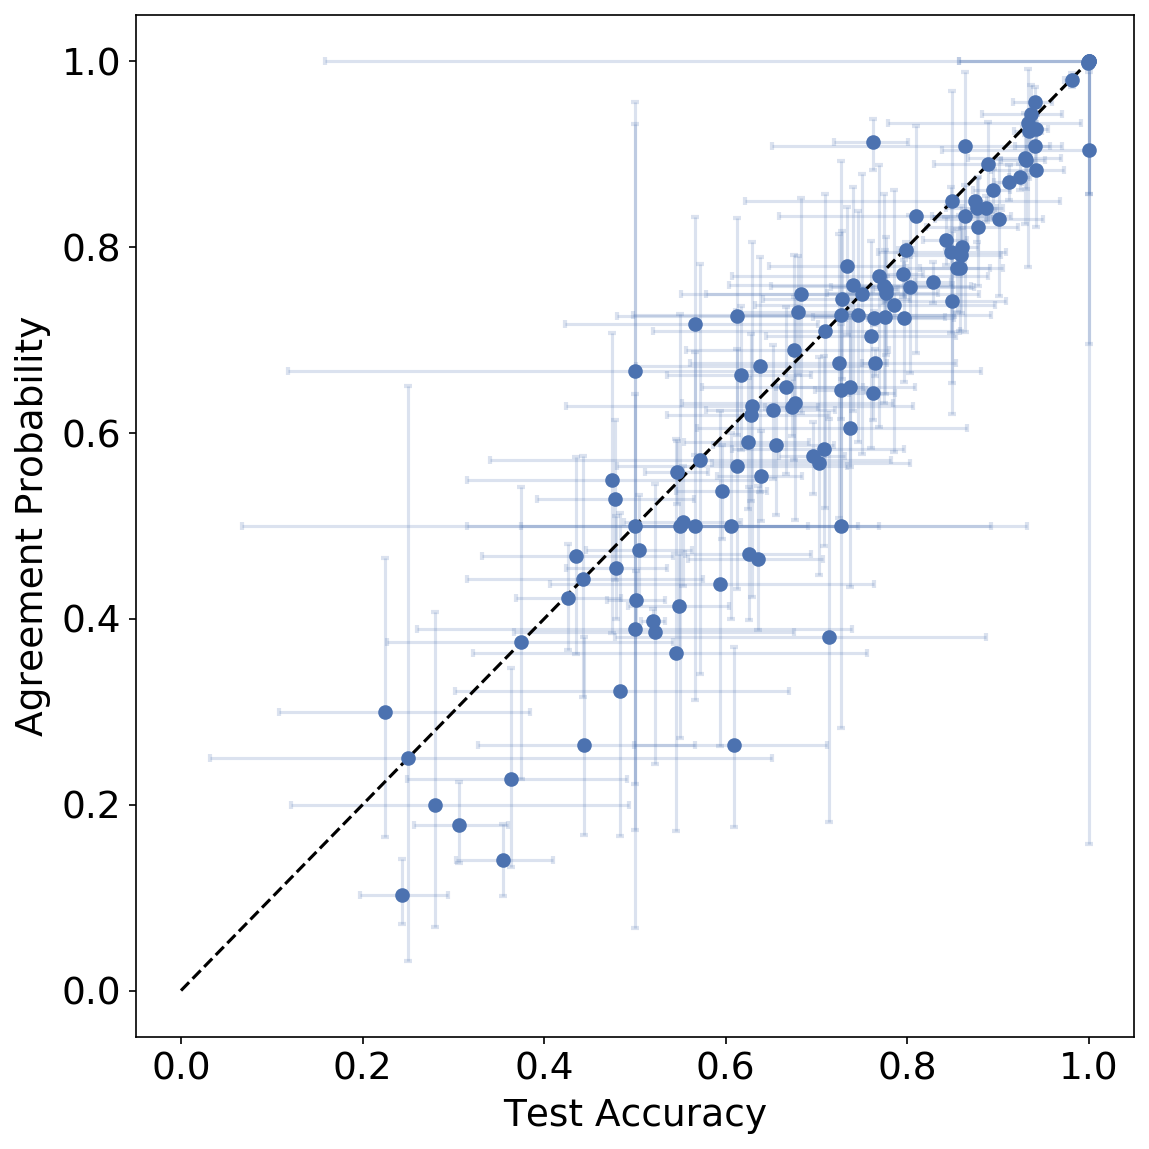

In [69]:
plot_df(df)

## Averaged Runs

In [156]:
df_list =  gload('gs://ANONYMOUS/results/uci/aggr')

(2, 121)


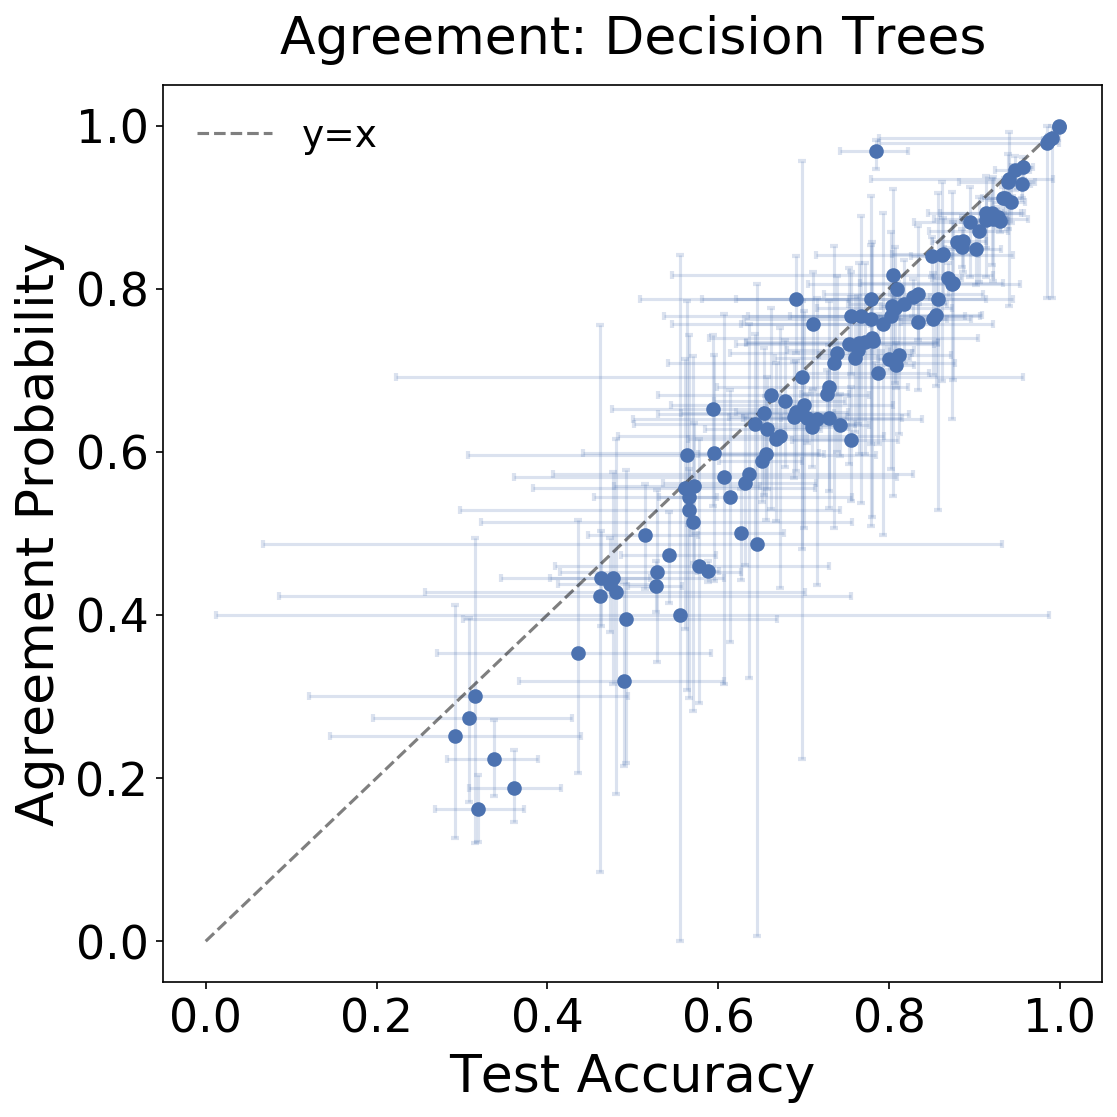

In [157]:
fig, ax = plot_df_list(df_list, selector = lambda d: d)
fig.savefig('./figs/uci_agreementFull_avg.png')

In [158]:
def get_mean_df(df_list):
    df_list = [df.set_index('name') for df in df_list]
    avg_df = pd.concat(df_list).groupby(level=0).mean()
    return avg_df

mean_df = get_mean_df(df_list)

In [96]:
mean_df

,n,n_tr,n_te,num_classes,num_features,acc1,acc2,aggr
name,,,,,,,,
abalone,4177,1670,837,3,8,0.554468,0.551649,0.535818
acute-inflammation,120,48,24,2,6,0.955833,0.947083,0.915417
acute-nephritis,120,48,24,2,6,0.973333,0.972083,0.958750
adult,48842,19536,9770,2,14,0.805593,0.806439,0.796603
annealing,898,359,180,5,31,0.877056,0.869778,0.831389
...,...,...,...,...,...,...,...,...
wine,178,71,36,3,13,0.836944,0.840833,0.765278
wine-quality-red,1599,639,321,6,11,0.514393,0.518224,0.465421
wine-quality-white,4898,1959,980,7,11,0.488755,0.485480,0.417276


(2, 92)


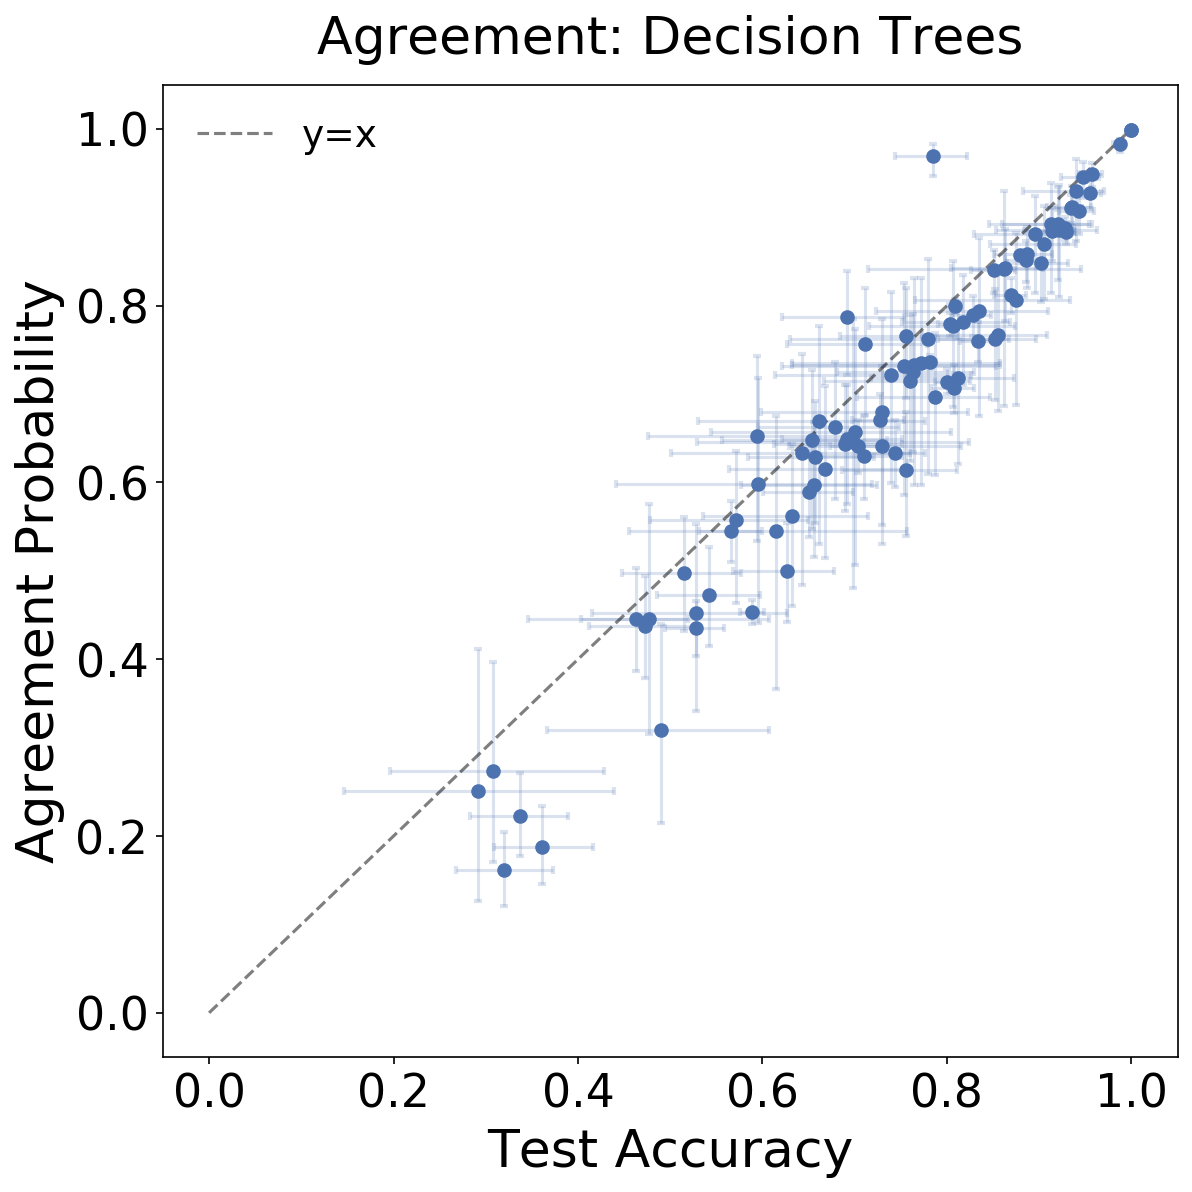

In [167]:
d = mean_df
fig, ax = plot_df(d[d['n'] >= 200])
fig.tight_layout()
fig.savefig('./figs/uci_agreement200_avg.png', bbox_inches = 'tight')

In [144]:
def make_table(df, mean_df):
    s = ""
    df = df.set_index('name')
    ncols = 7
    
    s += '\\begin{tabular}{' + ('l'* ncols) + '} \n'
    s += '\\toprule \\\\ \n'
    s += 'Name & $n$ & $d$\
    & Classes & Test Acc. F1 ( mean )\
    & Agreement Probability ( mean ) \\\\ \n'
    s += '\\midrule \\\\ \n'
    
    for name in df.index:
        r = mean_df.loc[name]
        rs = df.loc[name]
        n = int(r['n'])
        d = int(r['num_features'])
        c = int(r['num_classes'])
        a1, g = rs['acc1'], rs['aggr']
        ma1, mg = r['acc1'], r['aggr']
        
        cols = [f'\\verb!{name}!',
         f'{n}', f'{d}', f'{c}',
         f'{a1:.2f} ({ma1:.2f})',
         f'{g:.2f} ({mg:.2f})'
        ]
        
        s += ' & '.join(cols) + '\\\\ \n'
    
    s += '\\bottomrule \n'
    s += '\\end{tabular} \n'
    return s
        

In [145]:
s = make_table(df, mean_df)
print(s)
%store s > uci_results.tex

\begin{tabular}{lllllll} 
\toprule \\ 
Name & $n$ & $d$    & Classes & Test Acc. F1 ( mean )    & Agreement Probability ( mean ) \\ 
\midrule \\ 
\verb!abalone! & 4177 & 8 & 3 & 0.55 (0.55) & 0.56 (0.54)\\ 
\verb!acute-inflammation! & 120 & 6 & 2 & 1.00 (0.96) & 1.00 (0.92)\\ 
\verb!acute-nephritis! & 120 & 6 & 2 & 1.00 (0.97) & 1.00 (0.96)\\ 
\verb!adult! & 48842 & 14 & 2 & 0.80 (0.81) & 0.80 (0.80)\\ 
\verb!annealing! & 898 & 31 & 5 & 0.88 (0.88) & 0.82 (0.83)\\ 
\verb!arrhythmia! & 452 & 262 & 13 & 0.43 (0.50) & 0.47 (0.43)\\ 
\verb!audiology-std! & 196 & 59 & 18 & 0.38 (0.50) & 0.38 (0.38)\\ 
\verb!balance-scale! & 625 & 4 & 3 & 0.73 (0.75) & 0.74 (0.69)\\ 
\verb!balloons! & 16 & 4 & 2 & 0.50 (0.54) & 0.50 (0.53)\\ 
\verb!bank! & 4521 & 16 & 2 & 0.84 (0.85) & 0.81 (0.84)\\ 
\verb!blood! & 748 & 4 & 2 & 0.73 (0.71) & 0.78 (0.73)\\ 
\verb!breast-cancer! & 286 & 9 & 2 & 0.64 (0.63) & 0.67 (0.63)\\ 
\verb!breast-cancer-wisc! & 699 & 9 & 2 & 0.94 (0.93) & 0.94 (0.93)\\ 
\verb!breast-can

In [150]:
df.iloc[30:]

,name,n,n_tr,n_te,num_classes,num_features,acc1,acc2,aggr
30,ecoli,336,134,68,8,7,0.676471,0.691176,0.632353
31,energy-y1,768,307,154,3,8,0.941558,0.935065,0.883117
32,energy-y2,768,307,154,3,8,0.889610,0.909091,0.889610
33,fertility,100,40,20,2,9,0.850000,0.700000,0.850000
34,flags,194,77,40,8,28,0.475000,0.550000,0.550000
...,...,...,...,...,...,...,...,...,...
116,wine,178,71,36,3,13,0.750000,0.888889,0.750000
117,wine-quality-red,1599,639,321,6,11,0.479751,0.542056,0.454829
118,wine-quality-white,4898,1959,980,7,11,0.501020,0.480612,0.420408
119,yeast,1484,593,298,10,8,0.426174,0.453020,0.422819


In [152]:
clopper_pearson(500,1000,alpha=0.05)

(0.4685491729717874, 0.5314508270282126)